# Replicating SVM Recession Prediction

## Data Fetching

### Labels from NBER
This group of data is employed as labels of recession and expansion. Data fetched from https://www.nber.org/cycles/cyclesmain.html. Expansions are defined as the previous trough month (excluded) to the current peak month (included); recessions are defined as previous peak month (excluded) to the current trough month (included).

### Variable 1 of nonfarm payrolls
This group of variable stands for information from labor market. Data fetched from https://fred.stlouisfed.org/series/PAYEMS. It is the nonfarm payrolls from the Employment Situation Report published by the Bureau of Labor Statistics (BLS). Then take the log difference of it.

### Variable 2 of S&P500 monthly average
This group of variable stands for information from stock market. Data fetched from https://finance.yahoo.com/quote/%5EGSPC/history. It is the daily historical data of S&P500 from 1/1/1959 to 9/30/2019. Then we take a monthly average and then a log difference of it.

### Variable 3 of ISM Production Index
This group of variable stands for information from goods market. Data collected from https://www.instituteforsupplymanagement.org/ISMReport/MfgROB.cfm?SSO=1#production and https://ycharts.com/indicators/us_ism_manufacturing_production_index. It is published by ISM monthly.

### Variable 4 of 10-year Treasury yield minus the fed funds rate
This group of variable stands for information from bonds market.Data fetched from https://www.multpl.com/10-year-treasury-rate/table/by-month and https://fred.stlouisfed.org/series/FEDFUNDS. Then take difference of them.

---

## Data Cleaning
First convert labels from "trough month numbers" and "peak month numbers" to month numbers with recession and expension labels (1 for recession, 0 for expension). Discard the month number column.
Then take log-difference of variable 1 and log-difference monthly-average of variable 2.

The after-processed 5 groups of data all contain only one column which is their value from Feburary 1959 to September 2019 (all 728 lines excluding title). Collabrate them into one single matrix (728 x 5, excluding column names), we have it as input matrix.

---

## Parameter Tuning
According to the paper we use 10-fold cross validation on the first 100 dates to determine hyper-parameters (gamma, C).

(In fact the paper claims that they fixed gamma as 1/4, "the inverse of number of predictors". However, this number of gamma proves a relatively pool performance. Hence we use gridsearchCV to tune it together with gamma.)

In [12]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# read dataset to pandas dataframe
data = pd.read_csv("recession2.csv")

def svm_cross_validation(train_x, train_y, c_region, g_region):
    from sklearn.model_selection import GridSearchCV
    model = SVC(kernel='rbf', probability=True)
    param_grid = {'C': c_region, 'gamma': g_region}
    grid_search = GridSearchCV(model, param_grid, n_jobs = 4, verbose=1, cv = 10)
    grid_search.fit(train_x, train_y)
    grid_results = grid_search.cv_results_
    #print(grid_results)
    best_parameters = grid_search.best_estimator_.get_params()
    #for para, val in list(best_parameters.items()):
    #    print(para, val)
    model = SVC(kernel='rbf', C=best_parameters['C'], gamma=best_parameters['gamma'], probability=True)
    model.fit(train_x, train_y)
    return model

XX_train = data.drop('labels', axis=1)[0:100]
yy_train = data['labels'][0:100]
svm_cross_validation(XX_train, yy_train, [1.44,1.48,1.52,1.56,1.6,1.64,1.68,1.72,1.76], [2.42,2.44,2.46,2.48,2.5,2.52,2.54,2.56,2.58])

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 199 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 810 out of 810 | elapsed:    6.2s finished


SVC(C=1.44, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=2.42, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

As the result shows, we gain the best parameters (gamma = 2.54, C = 1.56) after several times of narrowing the region of gridsearch.

## Training and Testing

However, different from their positive claim in the paper, this group of parameters perform quite unsatisfactorily in the following training and testing part. Some refinements will be discussed below.

[[354  23]
 [ 14  20]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       377
           1       0.47      0.59      0.52        34

    accuracy                           0.91       411
   macro avg       0.71      0.76      0.73       411
weighted avg       0.92      0.91      0.91       411



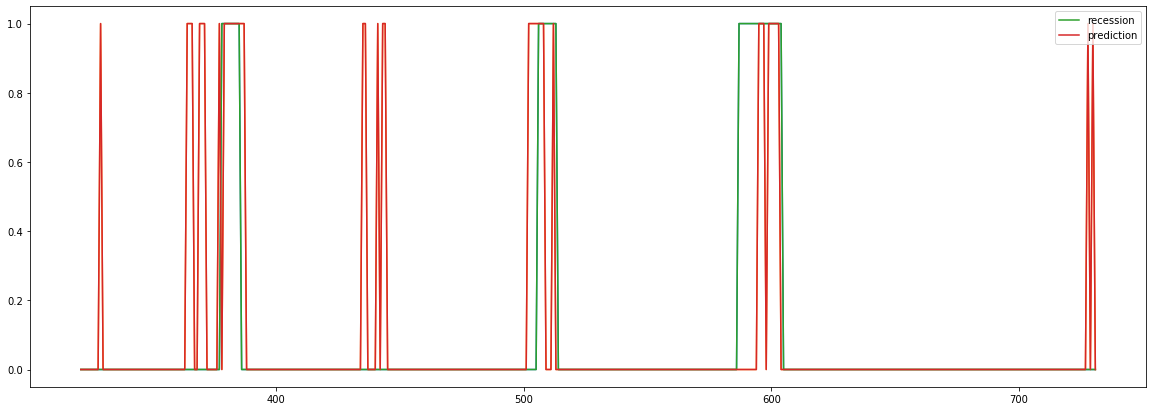

In [20]:
import math
X = data.drop('labels', axis=1)
y = data['labels']

#Splitting data into training and testing groups by rolling window
n = 1
y_pred = np.array([])
#rolling window size
for i in range(0,math.ceil((732-321+1)/n)-1):
    X_train = X[0:min(732, 320+i*n)]
    X_test = X[321+i*n:min(732, 321+(i+1)*n)]
    y_train = y[0:min(732, 320+i*n)]
    y_test = y[321+i*n:min(732, 321+(i+1)*n)]

    svclassifier = SVC(C = 4, kernel='rbf', gamma = 1.25, class_weight={0:1, 1:1.53},probability = True)
    svclassifier.fit(X_train, y_train)
    
    y_pred = np.append(y_pred, svclassifier.predict(X_test))
    #print(svclassifier.predict_proba(X_test))
#y_plot.insert(2, "pred", y_pred)
plt.figure(figsize=(20,7))
plt.plot(y_plot)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y[321:], y_pred))
print(classification_report(y[321:], y_pred))


#y_plot = y[321:].to_frame()
#y_plot["pred"] = y_pred
plt.plot(y_plot["labels"], label = "recession")
plt.plot(y_plot["pred"], label = "prediction")
plt.legend(loc='upper right')

## Refinement
This pool performance might be refined by the following methods:

1. Although the paper did not mention any normalization with their input matrix, a normalization could be helpful in this case, considering the first variable (10^-3) is 4 to 5 magnitudes smaller than the third variable (10^2).

2. Instead of splitting data into training and testing set naively, a rolling/ expanding window will perform reasonably better in time series models.

3. The paper employed a naive way of hyper-parameter tuning by performing 10-fold CV on the first 100 dates. This method actually ignores the unforeseeable property of time series data. A refined tuning method could be CV by a rolling/ expanding window.

            va_1      va_2      va_3      va_4    labels
va_1    1.000000  0.044300  0.595562 -0.038788 -0.577906
va_2    0.044300  1.000000  0.053642  0.099377 -0.119751
va_3    0.595562  0.053642  1.000000  0.240541 -0.601307
va_4   -0.038788  0.099377  0.240541  1.000000 -0.173018
labels -0.577906 -0.119751 -0.601307 -0.173018  1.000000


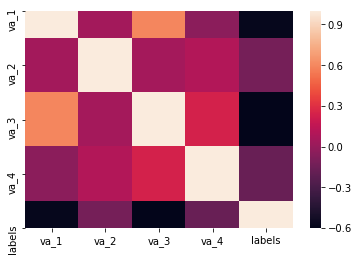

In [3]:
corr = pd.DataFrame.corr(data)
import seaborn as sns
ax = sns.heatmap(corr)
print(corr)

In [4]:
data = pd.read_csv("recession2.csv")

X = data.drop('labels', axis=1)
y = data['labels']

X_pre = X[0:168]
y_pre = y[0:168]
X_res = X[168:732]

svclassifier = SVC(C = 6, kernel='rbf', gamma = 1, class_weight={0:1, 1:1.53}, probability = True)
svclassifier.fit(X_pre, y_pre)

print(svclassifier.predict(X_res)[-10:732])
print(svclassifier.predict_proba(X_res)[-10:732])

[0 0 0 0 1 1 1 1 1 0]
[[0.9418291  0.0581709 ]
 [0.90934653 0.09065347]
 [0.92199544 0.07800456]
 [0.95192444 0.04807556]
 [0.32936573 0.67063427]
 [0.40273482 0.59726518]
 [0.67026688 0.32973312]
 [0.35542514 0.64457486]
 [0.48814611 0.51185389]
 [0.92098965 0.07901035]]
